<a href="https://colab.research.google.com/github/pinkicee/elastic-net-regularization-study/blob/main/elastic_net_timeseries_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================================
# 1. SETARI INITIALE SI INCARCAREA DATELOR
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

FILE_PATH = '/content/sample_data/PRSA_Data_Aotizhongxin_20130301-20170228.csv'
try:
    data = pd.read_csv(FILE_PATH)
    print(f"Setul de date '{FILE_PATH}' a fost încarcat. Dimensiune: {data.shape}")
except FileNotFoundError:
    print(f"EROARE: Fisierul '{FILE_PATH}' nu a fost gasit. Va rugAm sa verificati calea.")
    exit()

# Pre-procesare specifică setului de date
# 1. Creare coloană 'date' și setare ca index
data['date'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
data = data.set_index('date').drop(columns=['year', 'month', 'day', 'hour', 'No'])

# 2. Eliminare rânduri cu variabila țintă lipsă
data.dropna(subset=['PM2.5'], inplace=True)

# 3. Definirea X și y
X = data.drop('PM2.5', axis=1)
y = data['PM2.5']

# 4. Transformarea logaritmică a variabilei țintă (recomandat pentru metrici mai bune)
y = np.log1p(y)

# 5. Împărțirea datelor (fără amestecare pentru date de serie de timp)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"Dimensiunea setului de antrenament: {X_train.shape}")
print(f"Dimensiunea setului de testare: {X_test.shape}")

Setul de date '/content/sample_data/PRSA_Data_Aotizhongxin_20130301-20170228.csv' a fost încarcat. Dimensiune: (35064, 18)
Dimensiunea setului de antrenament: (27311, 12)
Dimensiunea setului de testare: (6828, 12)


In [ ]:
# ==============================================================================
# 2. PRE-PROCESAREA DATELOR (PIPELINE)
# ==============================================================================

# Identificarea tipurilor de coloane
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist() # Contine 'wd' (directia vantului)

# Pipeline 1: Date Numerice
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Umple NaNs cu mediana
    ('scaler', StandardScaler())                    # Scaleaza la medie 0, varianta 1 (esential pentru regularizare)
])

# Pipeline 2: Date Categorice
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Umple NaNs cu cea mai frecventa valoare
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-Hot Encoding
])

# Combinarea transformarilor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

X_processed_cols = preprocessor.fit_transform(X_train).shape[1]
print(f"\nNumar final de caracteristici dupa pre-procesare: {X_processed_cols}")


Numar final de caracteristici dupa pre-procesare: 27


Linear completat. RMSE Test: 0.5047, Parametrii: {'alpha': 'N/A'}
Ridge (L2) completat. RMSE Test: 0.5063, Parametrii: {'regressor__alpha': np.float64(100.0)}
Lasso (L1) completat. RMSE Test: 0.5073, Parametrii: {'regressor__alpha': np.float64(0.001)}
Elastic Net (L1+L2) completat. RMSE Test: 0.5125, Parametrii: {'regressor__alpha': np.float64(0.018329807108324356), 'regressor__l1_ratio': 0.01}


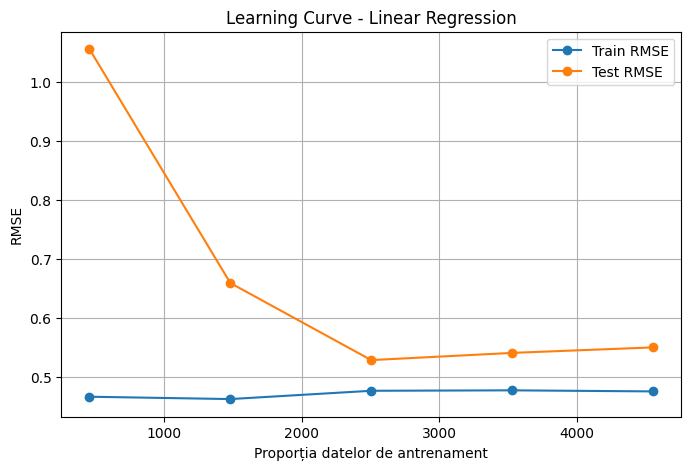

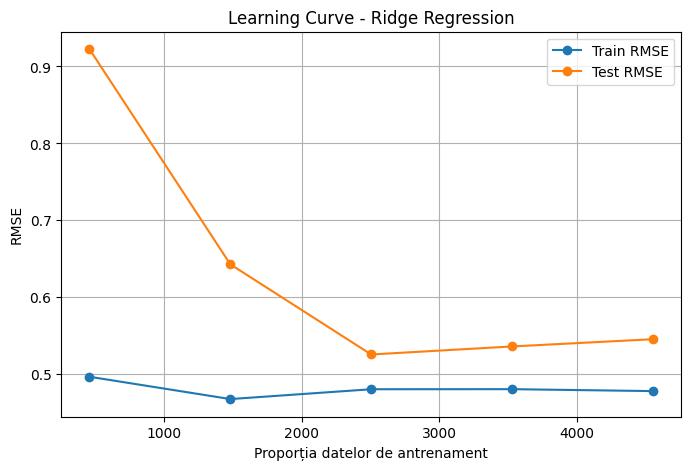

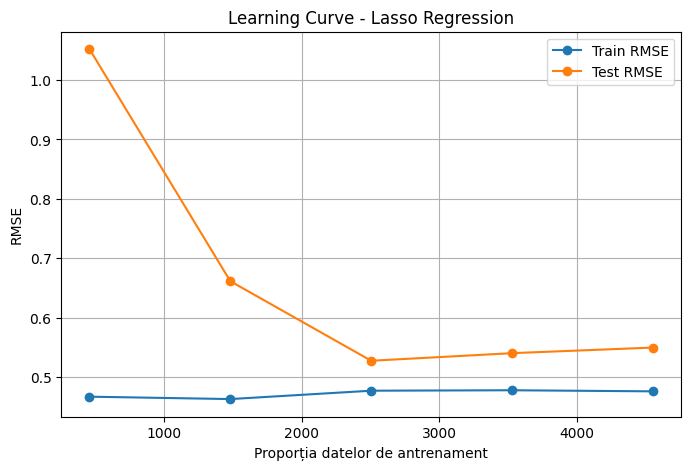

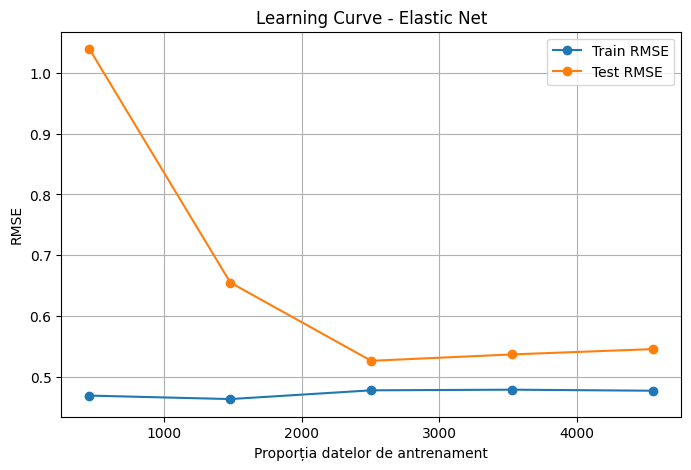


## 📊 Rezultate Comparative ale Performantei (Log PM2.5) — cu TimeSeriesSplit
                    RMSE_Train RMSE_Test   R2_Test  \
Linear                0.492601  0.504734  0.785528   
Ridge (L2)            0.492707  0.506259   0.78423   
Lasso (L1)            0.492932  0.507344  0.783304   
Elastic Net (L1+L2)   0.494412  0.512508   0.77887   

                                                           Best_Params  
Linear                                                {'alpha': 'N/A'}  
Ridge (L2)                                 {'regressor__alpha': 100.0}  
Lasso (L1)                                 {'regressor__alpha': 0.001}  
Elastic Net (L1+L2)  {'regressor__alpha': 0.018329807108324356, 're...  



In [ ]:
# ==============================================================================
# 3. IMPLEMENTAREA SI OPTIMIZAREA MODELULUI (TimeSeriesSplit + GridSearchCV)
# ==============================================================================

from sklearn.model_selection import TimeSeriesSplit

# Validare pentru serii temporale
tscv = TimeSeriesSplit(n_splits=5)

# Gama de alpha
ridge_alphas = np.logspace(-4, 2, 50)
lasso_alphas = np.logspace(-3, 1, 30)
enet_alphas  = np.logspace(-3, 0, 20)

results = {}

def run_model_comparison(model_name, regressor, param_grid):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', regressor)])

    if model_name != 'Linear':
        search = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            scoring='neg_mean_squared_error',
            cv=tscv,            # <–– schimbare importantă
            n_jobs=-1
        )
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_
    else:
        best_model = pipeline
        best_model.fit(X_train, y_train)
        best_params = {'alpha': 'N/A'}

    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    y_train_pred = best_model.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

    results[model_name] = {
        'RMSE_Test': rmse,
        'RMSE_Train': rmse_train,
        'R2_Test': r2_score(y_test, y_pred),
        'Best_Params': best_params,
        'Model': best_model
    }

    print(f"{model_name} completat. RMSE Test: {rmse:.4f}, Parametrii: {best_params}")


# 1. Linear Regression
run_model_comparison('Linear', LinearRegression(), {})

# 2. Ridge Regression
run_model_comparison(
    'Ridge (L2)',
    Ridge(random_state=42),
    {'regressor__alpha': ridge_alphas}
)

# 3. Lasso Regression
run_model_comparison(
    'Lasso (L1)',
    Lasso(random_state=42, max_iter=20000),
    {'regressor__alpha': lasso_alphas}
)

# 4. Elastic Net (L1+L2) — grid mai fin în jur de 0.1
enet_l1_ratios = [0.01, 0.05, 0.1, 0.2, 0.3]

enet_param_grid = {
    'regressor__alpha': enet_alphas,
    'regressor__l1_ratio': enet_l1_ratios
}

run_model_comparison(
    'Elastic Net (L1+L2)',
    ElasticNet(random_state=42, max_iter=20000),
    enet_param_grid
)

# ------------------------------------------------------------------------------
# Learning Curves cu TimeSeriesSplit
# ------------------------------------------------------------------------------

def plot_learning_curve(model, model_name):
    plt.figure(figsize=(8,5))
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train,
        y_train,
        cv=tscv,
        scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )

    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    test_rmse = np.sqrt(-test_scores.mean(axis=1))

    plt.plot(train_sizes, train_rmse, '-o', label='Train RMSE')
    plt.plot(train_sizes, test_rmse, '-o', label='Test RMSE')
    plt.title(f"Learning Curve - {model_name}")
    plt.xlabel("Proporția datelor de antrenament")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.legend()
    plt.show()


# Learning curves
plot_learning_curve(results['Linear']['Model'], "Linear Regression")
plot_learning_curve(results['Ridge (L2)']['Model'], "Ridge Regression")
plot_learning_curve(results['Lasso (L1)']['Model'], "Lasso Regression")
plot_learning_curve(results['Elastic Net (L1+L2)']['Model'], "Elastic Net")


# ------------------------------------------------------------------------------
# Rezultate finale
# ------------------------------------------------------------------------------
results_df = pd.DataFrame(results).T
print("\n" + "="*70)
print("## 📊 Rezultate Comparative ale Performantei (Log PM2.5) — cu TimeSeriesSplit")
print(results_df[['RMSE_Train', 'RMSE_Test', 'R2_Test', 'Best_Params']].sort_values(by='RMSE_Test'))
print("="*70 + "\n")


Lasso a eliminat: 3 coeficienti.
Elastic Net a eliminat: 1 coeficienti.


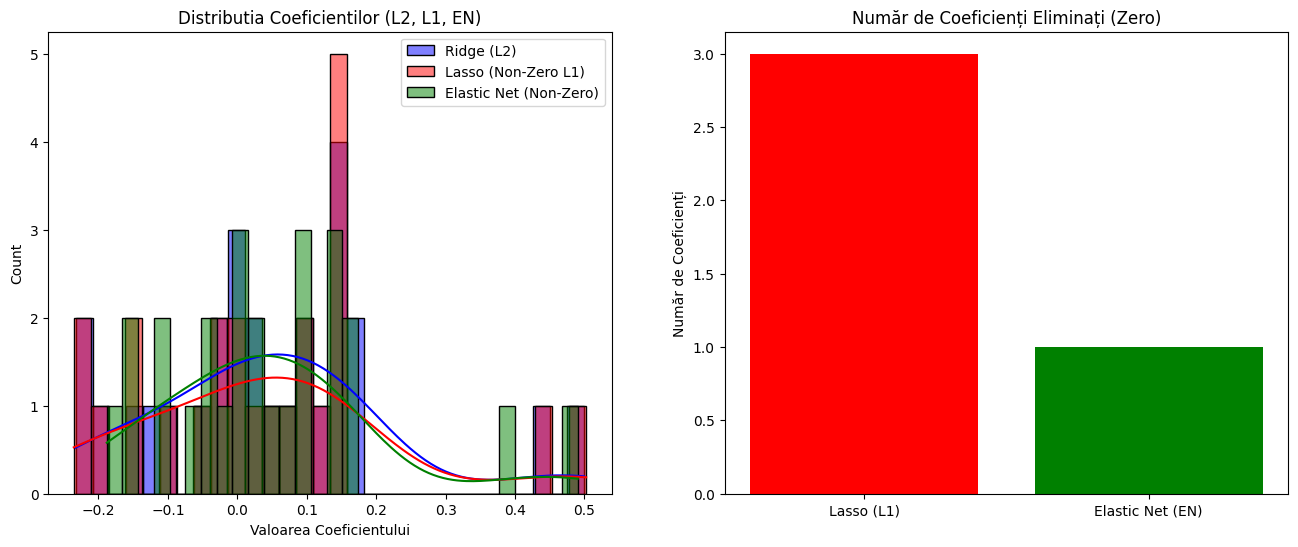

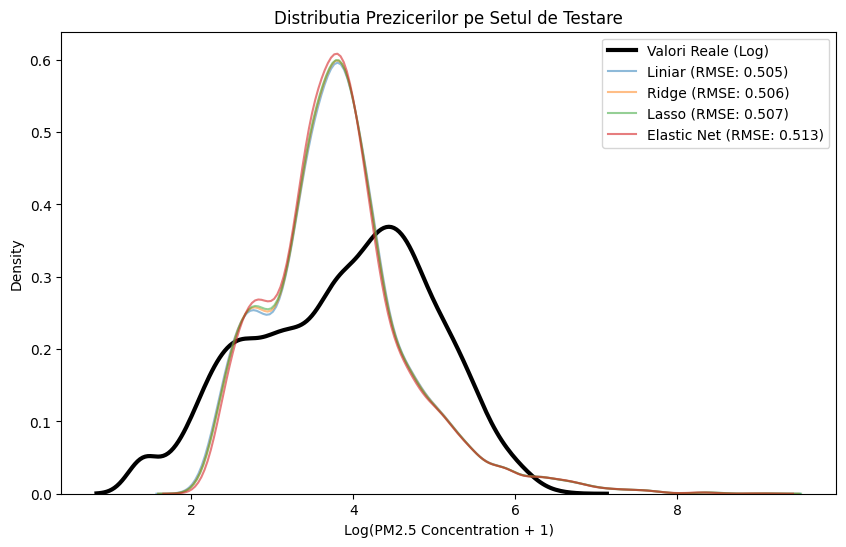

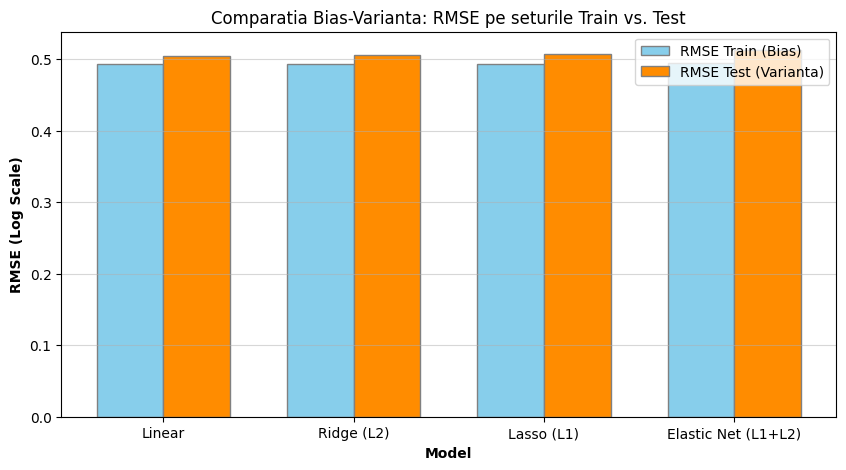

In [ ]:
# ==============================================================================
# 4. ANALIZA COEFICIENTILOR SI VIZUALIZARE
# ==============================================================================

# Obtinerea numelor de caracteristici
feature_names = results['Linear']['Model']['preprocessor'].get_feature_names_out()

# Extragerea coeficientilor
coef_lin = results['Linear']['Model']['regressor'].coef_
coef_ridge = results['Ridge (L2)']['Model']['regressor'].coef_
coef_lasso = results['Lasso (L1)']['Model']['regressor'].coef_
coef_en = results['Elastic Net (L1+L2)']['Model']['regressor'].coef_ # Noul coeficient

# DataFrame pentru coeficienti (focus pe un subset)
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Linear_Reg_Coef': coef_lin,
    'Ridge_Coef': coef_ridge,
    'Lasso_Coef': coef_lasso,
    'EN_Coef': coef_en
})

# Analiza Coeficientilor Zero
lasso_zero_count = (np.abs(coef_lasso) < 1e-6).sum()
en_zero_count = (np.abs(coef_en) < 1e-6).sum()

print(f"Lasso a eliminat: {lasso_zero_count} coeficienti.")
print(f"Elastic Net a eliminat: {en_zero_count} coeficienti.")

# --- Vizualizare 1: Histograma Coeficientilor ---
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.histplot(coef_ridge, bins=30, kde=True, color='blue', label='Ridge (L2)', alpha=0.5)
sns.histplot(coef_lasso[np.abs(coef_lasso) > 1e-6], bins=30, kde=True, color='red', label='Lasso (Non-Zero L1)', alpha=0.5)
sns.histplot(coef_en[np.abs(coef_en) > 1e-6], bins=30, kde=True, color='green', label='Elastic Net (Non-Zero)', alpha=0.5)
plt.title('Distributia Coeficientilor (L2, L1, EN)')
plt.xlabel('Valoarea Coeficientului')
plt.legend()

plt.subplot(1, 2, 2)
# Plot numărul de coeficienți eliminați
ridge_zero_count = (np.abs(coef_ridge) < 1e-6).sum()
plt.bar(['Lasso (L1)', 'Elastic Net (EN)'], [lasso_zero_count, en_zero_count], color=['red', 'green'])
plt.title('Număr de Coeficienți Eliminați (Zero)')
plt.ylabel('Număr de Coeficienți')
plt.show()

# --- Vizualizare 2: Distributia Prezicerilor (KDE) ---
y_pred_lin = results['Linear']['Model'].predict(X_test)
y_pred_ridge = results['Ridge (L2)']['Model'].predict(X_test)
y_pred_lasso = results['Lasso (L1)']['Model'].predict(X_test)
y_pred_en = results['Elastic Net (L1+L2)']['Model'].predict(X_test)

plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Valori Reale (Log)', color='black', linewidth=3)
sns.kdeplot(y_pred_lin, label=f'Liniar (RMSE: {results["Linear"]["RMSE_Test"]:.3f})', alpha=0.5)
sns.kdeplot(y_pred_ridge, label=f'Ridge (RMSE: {results["Ridge (L2)"]["RMSE_Test"]:.3f})', alpha=0.5)
sns.kdeplot(y_pred_lasso, label=f'Lasso (RMSE: {results["Lasso (L1)"]["RMSE_Test"]:.3f})', alpha=0.5)
sns.kdeplot(y_pred_en, label=f'Elastic Net (RMSE: {results["Elastic Net (L1+L2)"]["RMSE_Test"]:.3f})', alpha=0.6)
plt.title('Distributia Prezicerilor pe Setul de Testare')
plt.xlabel('Log(PM2.5 Concentration + 1)')
plt.legend()
plt.show()

# --- Vizualizare 3: Bias-Varianta (pentru partea scrisa) ---
# Varianta este reflectata de diferenta dintre performanta pe Test si Train
rmse_train = results_df['RMSE_Train']
rmse_test = results_df['RMSE_Test']
model_names = results_df.index

plt.figure(figsize=(10, 5))
bar_width = 0.35
r1 = np.arange(len(model_names))
r2 = [x + bar_width for x in r1]

plt.bar(r1, rmse_train, color='skyblue', width=bar_width, edgecolor='grey', label='RMSE Train (Bias)')
plt.bar(r2, rmse_test, color='darkorange', width=bar_width, edgecolor='grey', label='RMSE Test (Varianta)')

plt.xlabel('Model', fontweight='bold')
plt.ylabel('RMSE (Log Scale)', fontweight='bold')
plt.xticks([r + bar_width/2 for r in r1], model_names)
plt.title('Comparatia Bias-Varianta: RMSE pe seturile Train vs. Test')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()


In [ ]:
# ==============================================================================
# 5.REPRODUCERE
# ==============================================================================
for model_name, info in results.items():
    joblib.dump(info['Model'], f"/content/{model_name.replace(' ', '_')}.pkl")

print("Modelele au fost salvate cu succes!")


Modelele au fost salvate cu succes!


/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


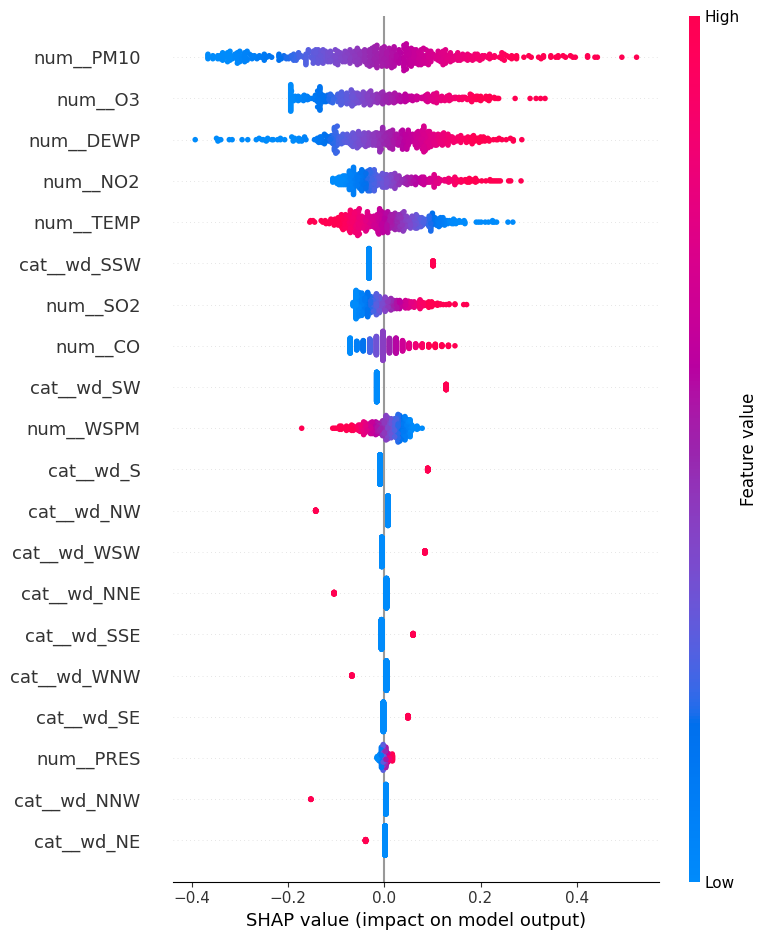

In [ ]:
# ==============================================================================
# 6. ANALIZA SHAP
# ==============================================================================
shap.initjs()

# Modelul final Elastic Net
model_en = results['Elastic Net (L1+L2)']['Model']

# SHAP necesită input numeric
X_sample = preprocessor.transform(X_test[:500])

explainer = shap.LinearExplainer(model_en['regressor'], X_sample, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_sample)

feature_names_processed = model_en['preprocessor'].get_feature_names_out()
shap.summary_plot(shap_values, X_sample, feature_names=feature_names_processed)